# DNA-GAST

This notebook explores the utilization of the GAST model for high-dimensional set elements in the form of pre-trained embeddings. The original DNA samples have been encoded and stored into *shelve* files located within the `./datasets/dna` directory.

In [1]:
%load_ext cython

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import time
import shelve
from sklearn.manifold import MDS

from IPython import display

import settransformer as sf

import common

## Configuration

In [3]:
strategy = common.strategy("gpu:0")
# strategy = common.strategy(multi_gpu=True)

In [4]:
# Use the original implementation of multihead attention
# from the official Pytorch implementation of set transformer
sf.config("use_keras_mha", False)

False

In [5]:
KMERS = 3
SEQUENCE_LENGTH = 150

## Pre-trained Embedding Model

This model is a pre-trained embedding model designed for 3-mer 128-dim embeddings

In [6]:
sequence_length = int(SEQUENCE_LENGTH / KMERS)
num_tokens = 5**KMERS
embed_dim = 32
latent_dim = 128
num_heads = 8
enc_stack = 1
dec_stack = 1

with strategy.scope():
    # Encoder
    y = x = keras.layers.Input((sequence_length,))
    y = keras.layers.Embedding(input_dim=num_tokens, output_dim=embed_dim)(y)
    y = common.FixedPositionEmbedding(length=sequence_length, embed_dim=embed_dim)(y)
    for _ in range(enc_stack):
        y = common.TransformerBlock(embed_dim, num_heads, ff_dim=embed_dim)(y)
    y = keras.layers.Flatten()(y)
    y = keras.layers.Dense(latent_dim)(y)
    encoder = keras.Model(x, y)

    # Decoder
    y = x = keras.layers.Input((encoder.output.shape[1:]))
    y = keras.layers.Dense(sequence_length*embed_dim)(y)
    y = keras.layers.Reshape((-1, embed_dim))(y)
    y = embed = common.FixedPositionEmbedding(length=sequence_length, embed_dim=embed_dim)(y)
    for _ in range(dec_stack):
        y = common.TransformerBlock(embed_dim, num_heads, ff_dim=embed_dim)(y)
        y = keras.layers.Add()((embed, y))
    y = keras.layers.Dense(num_tokens, activation="softmax")(y)
    decoder = keras.Model(x, y)

    # Coupled model
    y = x = keras.layers.Input(encoder.input.shape[1:])
    y = encoder(y)
    y = decoder(y)
    embed_model = keras.Model(x, y)
    embed_model.encoder = encoder
    embed_model.decoder = decoder
    embed_model.compile(
        keras.optimizers.Nadam(1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=[keras.metrics.SparseCategoricalAccuracy()])
    embed_model.summary()
    
    embed_model.load_weights("./models/embedding.h5")

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
model (Functional)           (None, 128)               246336    
_________________________________________________________________
model_1 (Functional)         (None, 50, 125)           247933    
Total params: 494,269
Trainable params: 494,269
Non-trainable params: 0
_________________________________________________________________


## Sample Embedding Generation

The following code iterates over all available processed sample files and predicts learned embeddings of augmented DNA samples to a corresponding output file. This process may take a while on the first run as it needs to create the sample stores. Existing stores will be skipped to save time.

In [7]:
if not os.path.exists("./datasets/dna/embedded"):
    os.mkdir("./datasets/dna/embedded")

In [8]:
def augment(sample, sequence_length):
    offset = np.random.randint(sample.shape[0] - sequence_length + 1)
    return sample[offset:sequence_length+offset]

In [9]:
def sample_generator(store, batch_size):
    num_samples = store["length"]
    kmer_sequence_length = int(SEQUENCE_LENGTH / KMERS)
    kmer_powers = np.full(KMERS, 5)**np.arange(KMERS - 1, -1, -1)

    for batch_index in range(0, num_samples, batch_size):
        num_samples_in_batch = min(num_samples - batch_index, batch_size)
        samples = np.empty(shape=(num_samples_in_batch, SEQUENCE_LENGTH), dtype=np.int32)
        for i in range(0, num_samples_in_batch):
            samples[i] = augment(store[str(batch_index + i)][0], SEQUENCE_LENGTH)
        batch = np.sum(samples.reshape((num_samples_in_batch, -1, KMERS)) * kmer_powers, axis=2)
        yield batch

In [10]:
files = [f[:-3] for f in os.listdir("./datasets/dna") if f.endswith(".db")]
files

['spring_2016-04-22',
 'spring_2019-05-14',
 'fall_2017-10-13',
 'spring_2020-05-11',
 'fall_2016-10-07',
 'spring_2017-05-02',
 'spring_2018-04-23']

In [11]:
batch_size = 128

with strategy.scope():
    with common.Benchmark() as progress:
        for file in files:
            dest = f"./datasets/dna/embedded/3mer_128_{file}"
            if os.path.exists(dest + ".db"):
                continue
            in_store = shelve.open(f"./datasets/dna/{file}")
            out_store = shelve.open(dest)
            num_samples = in_store["length"]
            num_batches = int(np.ceil(num_samples / batch_size))
            for i, batch in enumerate(sample_generator(in_store, batch_size)):
                for j, sample in enumerate(encoder(batch)):
                    out_store[str(batch_size*i+j)] = sample
                print(f"\rBatch: {i+1}/{num_batches}", end="")
            print()
            out_store["length"] = num_samples
            out_store.close()
            in_store.close()
            progress.checkpoint(f"File: {file} completed, {num_samples:,} processed")

Total time: 0.00044274330139160156 seconds.


## DNA Dataset

Load the DNA samples into a sample generator

In [12]:
files = os.listdir("./datasets/dna")
files = [f"./datasets/dna/{f[:-3]}" for f in files if f.endswith(".db")]

In [13]:
files

['./datasets/dna/spring_2016-04-22',
 './datasets/dna/spring_2019-05-14',
 './datasets/dna/fall_2017-10-13',
 './datasets/dna/spring_2020-05-11',
 './datasets/dna/fall_2016-10-07',
 './datasets/dna/spring_2017-05-02',
 './datasets/dna/spring_2018-04-23']

In [14]:
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
KMERS = 3
SEQUENCE_LENGTH = 150
SUBSAMPLE_SIZE = 1000
BUFFER_SIZE = 20
NUM_WORKERS = 4
KMER_SEQUENCE_LENGTH = int(SEQUENCE_LENGTH / KMERS)
DNA_EMBED_DIM = 128

In [15]:
dna_data_generator = common.MultiprocessDnaSampler(
    files=files,
    kmers=KMERS,
    sequence_length=SEQUENCE_LENGTH,
    batch_size=GLOBAL_BATCH_SIZE,
    subsample_size=SUBSAMPLE_SIZE,
    buffer_size=BUFFER_SIZE,
    num_workers=NUM_WORKERS)

train_dataset = tf.data.Dataset.from_generator(
    dna_data_generator.generator,
    output_types=(tf.int32),
    output_shapes=(
        tf.TensorShape([GLOBAL_BATCH_SIZE, SUBSAMPLE_SIZE, KMER_SEQUENCE_LENGTH])))

In [16]:
# train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

In [17]:
dna_data_generator.start()

## Model Architecture

In [20]:
NOISE_DIM = 64
EMBED_DIM = 192
LATENT_DIM = EMBED_DIM*4
NUM_HEADS = 12
NUM_ANCHORS = 48
MAX_SET_SIZE = SUBSAMPLE_SIZE

### Generator

In [21]:
with strategy.scope():
    noise = keras.layers.Input((NOISE_DIM,))
    cardinality = keras.layers.Input((1,), dtype=tf.int32)
    
    condition = tfa.layers.SpectralNormalization(keras.layers.Dense(NOISE_DIM))(noise)
    
    y1 = y = common.SampleSet(MAX_SET_SIZE, EMBED_DIM)(cardinality)
    
    # Condition the set
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y1 = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    y = keras.layers.Add()((y1, y))
    y = common.ConditionedISAB(embed_dim=EMBED_DIM, dim_cond=NOISE_DIM, num_heads=NUM_HEADS, num_anchors=NUM_ANCHORS)((y, condition))
    
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(DNA_EMBED_DIM, use_bias=False))(y)
    generator = keras.Model((noise, cardinality), y)
    generator.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
sample_set (SampleSet)          (None, None, 192)    384000      input_5[0][0]                    
__________________________________________________________________________________________________
spectral_normalization (Spectra (None, 64)           4224        input_4[0][0]                    
____________________________________________________________________________________________

### Discriminator

In [22]:
with strategy.scope():
    y = x = keras.layers.Input((None, DNA_EMBED_DIM))
    y1 = y = tfa.layers.SpectralNormalization(keras.layers.Dense(EMBED_DIM))(y)
#     e0 = sf.ISE(1, LATENT_DIM, 4)(y)
    
    enc = []
    for i in range(3):
        y = sf.ISAB(EMBED_DIM, num_heads=NUM_HEADS, num_induce=NUM_ANCHORS)(y)
        y1 = y = keras.layers.Add()((y1, y))
        enc.append(sf.ISE(1, EMBED_DIM, NUM_HEADS)(y))

    y = keras.layers.Concatenate()(enc)

    y = tfa.layers.SpectralNormalization(keras.layers.Dense(1))(y)

    discriminator = keras.Model(x, y)
    discriminator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
spectral_normalization_6 (Spect (None, None, 192)    24960       input_6[0][0]                    
__________________________________________________________________________________________________
induced_set_attention_block (In (None, None, 192)    305664      spectral_normalization_6[0][0]   
__________________________________________________________________________________________________
add_4 (Add)                     (None, None, 192)    0           spectral_normalization_6[0][0]   
                                                                 induced_set_attention_block

### Coupled Model

In [23]:
with strategy.scope():
    x1 = keras.layers.Input(generator.input_shape[0][1:])
    x2 = keras.layers.Input(generator.input_shape[1][1:])
    y = generator((x1, x2))
    y = discriminator(y)
    model = keras.Model((x1, x2), y)

## Loss Functions

Note: the original paper uses a version of Hinge loss. This implementation utilizes the basic binary crossentropy loss for the generator and discriminator.

In [24]:
with strategy.scope():
    loss_obj = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [25]:
# def generator_loss(fake_output):
#     loss = -tf.reduce_mean(fake_output)
#     return loss

# def discriminator_loss(real_output, fake_output):
#     real_loss = tf.reduce_mean(tf.maximum(1 - real_output, 0))
#     fake_loss = tf.reduce_mean(tf.maximum(1 + fake_output, 0))
#     loss = real_loss + fake_loss
#     return loss

def generator_loss(fake_output):
    loss = loss_obj(tf.ones_like(fake_output), fake_output)
    return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_obj(tf.ones_like(real_output), real_output)
    fake_loss = loss_obj(tf.zeros_like(fake_output), fake_output)
    loss = real_loss + fake_loss
    return tf.nn.compute_average_loss(loss, global_batch_size=GLOBAL_BATCH_SIZE)

## Optimizers

In [26]:
with strategy.scope():
    gen_optimizer = keras.optimizers.Adam(1e-4)
    disc_optimizer = keras.optimizers.Adam(1e-4)

In [27]:
def lr_schedule(optimizers):
    for optimizer in optimizers:
        optimizer.learning_rate.assign(optimizer.learning_rate*0.95)

## Training

It's worth noting that the generator conditions currently randomly samples points regardless of the given noise input. This causes generated preview digits to be inconsistant.

In [28]:
def train_step(real, k):
#     for _ in range(k):
    noise = tf.random.normal((BATCH_SIZE_PER_REPLICA, NOISE_DIM))
    n = tf.repeat(tf.constant([SUBSAMPLE_SIZE]), tf.shape(noise)[0])
    
    # Embed the given real sequences
    b = tf.reshape(real, (-1, KMER_SEQUENCE_LENGTH))
    embedded_real = embed_model.encoder(b)
    real = tf.reshape(embedded_real, (-1, SUBSAMPLE_SIZE, DNA_EMBED_DIM))
        
    with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:
        fake = generator((noise, n))
        fake_output = discriminator(fake)
        real_output = discriminator(real)
        
        disc_loss = discriminator_loss(real_output, fake_output)
        gen_loss = generator_loss(fake_output)
        
#         disc_loss = tf.reduce_mean(tf.maximum(1 - real_output, 0)) + tf.reduce_mean(tf.maximum(1 + fake_output, 0))
#         gen_loss = - tf.reduce_mean(fake_output)
    
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    
    return disc_loss, gen_loss

@tf.function()
def distributed_train_step(batch, k):
    losses = strategy.run(train_step, args=(batch, k))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, losses, axis=None)

In [29]:
# Used to preview during training
test_noise = tf.random.normal((5, NOISE_DIM))
n = tf.repeat(tf.constant([SUBSAMPLE_SIZE]), tf.shape(test_noise)[0])
disc_losses = []
gen_losses = []
step = 0
k = 1

In [30]:
# Training Loop
with strategy.scope():
    num_steps = 10000
    
    data_iterator = iter(train_dist_dataset)
    
    try:
    
        end_step = step + num_steps
        for step in range(step, end_step):

            if step % 100 == 0:
                test_store = shelve.open("./results/dna_gen")
                test_store[str(step)] = generator((test_noise, n))
                test_store.close()

            start = time.time()

            batch = next(data_iterator)[0]
            losses = distributed_train_step(batch, k)
            disc_loss = losses[0]
            gen_loss = losses[1]
            display.clear_output(wait=True)
            print(f"\rStep: {step}/{end_step}; {time.time() - start:.2}s; Generator loss: {gen_loss/(i+1)}; Discriminator loss: {disc_loss/(i+1)}", end="")
            disc_losses.append(disc_loss / (i+1))
            gen_losses.append(gen_loss / (i+1))

        #     if epoch % 10 == 0:
        #         model.save_weights(f"gast_epoch_{epoch}.h5")
    except KeyboardInterrupt as e:
        test_store.sync()

Step: 2211/10000; 0.18s; Generator loss: 3.6106903553009033; Discriminator loss: 0.72981196641922

In [31]:
model.save_weights("./models/dnagast.h5")

## Evaluation

After training, we can evaluate the model by comparing sample similarity using Chamfer distance. The similarity can be visualized using metric multi-dimensional scaling (MDS).

The following cell implements the Chamfer distance metric in Cython utilizing cityblock distance between points rather than euclidean as Manhattan distance can achieve more meaningful results for higher-dimension elements (https://bib.dbvis.de/uploadedFiles/155.pdf).

In [32]:
%%cython

cpdef float chamfer_distance_cython(float[:,:] a, float[:,:] b):
    cdef float total_dist = 0.0
    cdef float d
    cdef float min_d
    cdef int i, j, k
    cdef int len_a = len(a)
    cdef int len_b = len(b)
    cdef int point_width = len(a[0])
    for i in range(len_a):
        min_d = -1
        for j in range(len_b):
            d = 0.0
            for k in range(point_width):
                d += abs(b[j][k] - a[i][k])
            if d < min_d or min_d == -1.0:
                min_d = d
        total_dist += min_d
    return total_dist / len_a

## MDS of Embedded Samples

This first section computes the Chamfer distances and generates the MDS plot for the landmark samples.

In [33]:
NUM_LANDMARKS_PER_SAMPLE = 10

In [34]:
files = [f[:-3] for f in os.listdir("./datasets/dna") if f.endswith(".db")]
files

['spring_2016-04-22',
 'spring_2019-05-14',
 'fall_2017-10-13',
 'spring_2020-05-11',
 'fall_2016-10-07',
 'spring_2017-05-02',
 'spring_2018-04-23']

In [35]:
prefix = "./datasets/dna/embedded/3mer_128_"

### Subsampling

This cell loads a number of subsamples from each of the main sample files available. Specifically, this cell subsamples the full sample, taking only 1,000 DNA sequences at random without replacement for each subsample.

In [36]:
if os.path.exists("./results/dna_landmarks.npy"):
    print("Previous landmark subsamples loaded")
    samples = np.load("./results/dna_landmarks.npy")
    num_samples_per_file = NUM_LANDMARKS_PER_SAMPLE
    sample_size = samples.shape[1]
    embed_dim = samples.shape[2]
    
else:
    num_samples_per_file = NUM_LANDMARKS_PER_SAMPLE
    sample_size = 1000
    embed_dim = 128
    samples = np.empty((len(files)*num_samples_per_file, sample_size, embed_dim), dtype=np.float32)

    for i, file in enumerate(files):
        store = shelve.open(prefix + file)
        store_len = store["length"]
        for j in range(num_samples_per_file):
            for k, index in enumerate(np.random.choice(np.arange(store_len), sample_size, replace=False)):
                samples[i*num_samples_per_file+j][k] = store[str(index)]
    np.save("./results/dna_landmarks.npy", samples)

Previous landmark subsamples loaded


### Subsample Similarity with Chamfer Distance

This next cell computes the Chamfer distance between each of the chosen subsamples. If the distances have been computed previously, they will be loaded instead.

In [37]:
filename = "./results/dna_landmark_distances.npy"
if os.path.exists(filename):
    distances = np.load(filename)
    print("Previous distances loaded from file")
    
else:
    n = len(samples)

    distances = np.empty(shape=(n, n))
    with strategy.scope():
        with common.Benchmark():
            for i in range(n):
                distances[i][i] = 0.0
                for j in range(i+1, n):
                    # distances[i][j] = chamfer_distance.evaluate(samples[i], samples[j])
                    distances[i][j] = chamfer_distance_cython(samples[i], samples[j])
                    distances[j][i] = distances[i][j]
                    print(f"\rM[{i}][{j}]", end="")
        print()
    np.save(filename, distances)

Previous distances loaded from file


### Load GAN Subsamples from Shelve

In [38]:
steps = 1000 # Which step count to sample from
store = shelve.open("./results/dna_gen")
gen_samples = store[str(steps)]
store.close()

### Compute New Chamfer Distances

**Note:** We could speed this process up here by using Nystroem approximations... Not sure how yet though...

In [39]:
new_distances = np.zeros(np.add(distances.shape, gen_samples.shape[0]))
new_distances[:distances.shape[0], :distances.shape[1]] = distances

In [40]:
n = len(distances)
N = len(new_distances)
for i in range(n, N):
    new_distances[i][i] = 0.0
    for j in range(0, n):
        new_distances[i][j] = chamfer_distance_cython(gen_samples[i-n].numpy(), samples[j])
        new_distances[j][i] = new_distances[i][j]
    for j in range(i+1, N):
        new_distances[i][j] = chamfer_distance_cython(gen_samples[i-n].numpy(), gen_samples[j-n].numpy())
        new_distances[j][i] = new_distances[i][j]
        print(f"\rM[{i}][{j}]", end="")

M[73][74]

In [41]:
new_distances[70]

array([1405.53210449, 1419.32189941, 1425.29492188, 1419.03234863,
       1420.88525391, 1391.75866699, 1439.32983398, 1251.3302002 ,
       1346.53027344, 1428.57958984, 1469.4473877 , 1450.57592773,
       1483.40332031, 1442.38891602, 1437.13952637, 1500.20141602,
       1508.11547852, 1494.0480957 , 1481.0501709 , 1433.18127441,
       1444.96899414, 1468.66845703, 1449.80627441, 1419.33276367,
       1363.19763184, 1455.27844238, 1457.82885742, 1452.71105957,
       1484.60632324, 1449.64782715, 1457.9543457 , 1351.34545898,
       1452.8347168 , 1303.6237793 , 1480.12280273, 1397.38867188,
       1303.6237793 , 1471.0723877 , 1476.92565918, 1462.77685547,
       1396.28637695, 1382.8470459 , 1407.41162109, 1426.58581543,
       1402.80517578, 1419.97363281, 1398.32397461, 1396.20874023,
       1393.22692871, 1399.97717285, 1446.71740723, 1377.78503418,
       1347.16748047, 1428.27368164, 1373.25061035, 1476.90991211,
       1407.5612793 , 1471.22973633, 1449.36328125, 1448.57312

### MDS Plot

In [42]:
mds = MDS(n_components=2, metric=True, dissimilarity='precomputed')

In [43]:
dna_pca = mds.fit_transform(new_distances)
dna_pca.shape

(75, 2)

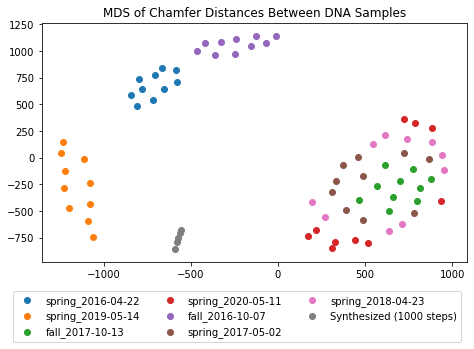

In [44]:
plt.figure(figsize=(7,5))
for i in range(0, num_samples_per_file*len(files), num_samples_per_file):
    plt.scatter(*dna_pca[i:i+num_samples_per_file].T)
plt.title("MDS of Chamfer Distances Between DNA Samples")
plt.scatter(*dna_pca[len(distances):].T)
plt.legend(files + [f"Synthesized ({steps} steps)"], loc="upper center", bbox_to_anchor=(0.46, -0.1), fancybox=True, ncol=3)
plt.tight_layout()
plt.show()